# SHP2CSV algorithm
## Importing libraries

In [1]:
from shapely.geometry import shape
from shapely.ops import unary_union
import fiona
import networkx as nx
import itertools
import matplotlib.pyplot as plt
from IPython.core.debugger import Tracer

## Importing and reading shp file

In [2]:
geoms =[shape(feature['geometry']) for feature in fiona.open("shp/Bogota_linea/Bogota_linea/Bogota_linea.shp") if feature['geometry'] != None]

## Converting `geoms` into a planar graph

In [3]:
res = unary_union(geoms)

## Creating a Graph object in order to print it
this part of the code is not needed, it is just for having an idea of the graph that is going to be exported

In [4]:
G = nx.Graph()
for line in res:
    for seg_start, seg_end in itertools.izip(list(line.coords),list(line.coords)[1:]):
        G.add_edge(seg_start, seg_end)

## Plotting the graph

/Users/MikeW/.virtualenvs/uber/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/MikeW/.virtualenvs/uber/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/MikeW/.virtualenvs/uber/lib/python2.7/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/MikeW/.virtualenvs/uber/lib/python2.7/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 

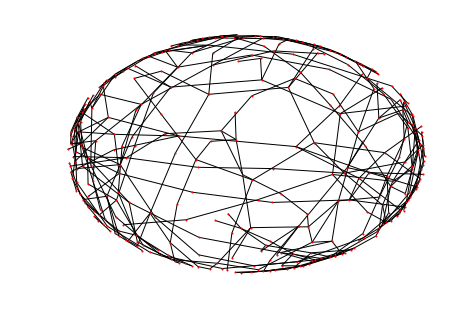

In [5]:
nx.draw(G, node_size=1)
plt.show()

## Creating sets

In [6]:
y = set()
x = set()
lengths = set()

nodes = set()
edges = set()

nodes_norm = list()
edges_norm = set()

## Creating a list of nodes

In [7]:
for line in res:
    for node in line.coords:
        nodes.add(node)
        x.add(node[0])
        y.add(node[1])

nodes = list(nodes)

## Normalizing the nodes coordinates

In [8]:
# Getting the max and min for x and y axis
x_max = max(x)
x_min = min(x)
y_max = max(y)
y_min = min(y)

# Normalizing

for node in nodes:
    node = (nodes.index(node),(node[0]-x_min)/(x_max-x_min),(node[1]-y_min)/(y_max-y_min))
    nodes_norm.append(node)

## Creating a list of edges

In [9]:
for line in res:
    #Tracer()()
    #print(line)
    last_coord = None
    lenght = len(line.coords)
    for coord in line.coords:
        if last_coord != None:
            print(last_coord,coord)
            edge = (nodes.index(last_coord),nodes.index(coord),line.length/lenght)
            lengths.add(line.length/lenght) #modify this
            edges.add(edge)
        last_coord = coord
        
    
edges = list(edges)

((-74.04824773636686, 4.741776032363936), (-74.04653056199992, 4.75147051500006))
((-74.02330094999989, 4.736896340000039), (-74.02268722999992, 4.738078530000047))
((-74.02268722999992, 4.738078530000047), (-74.02264690928212, 4.739319068538723))
((-74.02264690928212, 4.739319068538723), (-74.02260666999989, 4.740138270000039))
((-74.02260666999989, 4.740138270000039), (-74.02244723811903, 4.740600795920106))
((-74.02244723811903, 4.740600795920106), (-74.02224894999993, 4.741112430000024))
((-74.02224894999993, 4.741112430000024), (-74.02220067041297, 4.741580341130078))
((-74.02220067041297, 4.741580341130078), (-74.02219852099888, 4.741975017215675))
((-74.02219852099888, 4.741975017215675), (-74.02219373066403, 4.743135133424376))
((-74.02219373066403, 4.743135133424376), (-74.0221985899999, 4.744058780000041))
((-74.0221985899999, 4.744058780000041), (-74.02226872999992, 4.745324390000061))
((-74.02226872999992, 4.745324390000061), (-74.02235271999989, 4.746125930000084))
((-74.0

## Normalizing the cost of the edges

In [10]:
length_max = max(lengths)
length_min = min(lengths)

# normalizing length
for edge in edges:
    edge2 = (edges.index(edge),edge[0],edge[1],(edge[2]-length_min)/(length_max-length_min))
    edges_norm.add(edge2)

## printing results

In [11]:
nodes_norm

[(0, 0.6949488123836981, 0.7729146537898819),
 (1, 0.3735952308827867, 0.25247477606319335),
 (2, 0.6088203457670779, 0.1192482408319455),
 (3, 0.9499388109276139, 0.9299729959060011),
 (4, 0.6999911804920627, 0.4565592366142066),
 (5, 0.8317959012563855, 0.7863645866282314),
 (6, 0.9999639446810009, 0.9398737377548904),
 (7, 0.730435617925285, 0.8578198367480621),
 (8, 0.6186223231844655, 0.7065720437633737),
 (9, 0.7439621287731479, 0.38420273896331125),
 (10, 0.4000039707259912, 0.45534184175856596),
 (11, 0.7095072715465633, 0.4329169189117959),
 (12, 0.07439998479485875, 0.38151102490538863),
 (13, 0.8179000729465125, 0.7210446222067425),
 (14, 0.9986829073739935, 0.9356361722834313),
 (15, 0.45509107211393574, 0.5423337997234836),
 (16, 0.7302654956454082, 0.8583134255539848),
 (17, 0.47919489927111897, 0.27124422229530093),
 (18, 0.2945074342915352, 0.6262950799702954),
 (19, 0.5728524194563629, 0.5658487977135848),
 (20, 0.36574597019404564, 0.32821992308794623),
 (21, 0.369283

In [12]:
edges_norm

{(0, 36, 257, 0.06637301410855327),
 (1, 284, 222, 0.18691724565479143),
 (2, 234, 193, 3.7352097691367158e-06),
 (3, 172, 59, 0.32458904696125074),
 (4, 317, 21, 0.25969123909353625),
 (5, 327, 307, 0.33539532521690596),
 (6, 111, 159, 0.29822074268954984),
 (7, 272, 324, 0.19653705729014856),
 (8, 110, 117, 0.1956404138270054),
 (9, 299, 20, 0.19402421895480781),
 (10, 24, 143, 0.12515434786311194),
 (11, 245, 62, 0.05719572325241445),
 (12, 97, 92, 0.3468068318149535),
 (13, 159, 134, 0.20325850045702343),
 (14, 18, 107, 0.5800986111721059),
 (15, 68, 46, 0.15234720488299192),
 (16, 63, 259, 0.045873345038215385),
 (17, 302, 305, 0.2601192010438144),
 (18, 11, 298, 0.14486944024901785),
 (19, 261, 179, 0.47896200070913564),
 (20, 238, 28, 1.35182955626031e-05),
 (21, 275, 327, 0.4532550082103583),
 (22, 333, 144, 0.000899655377760971),
 (23, 73, 279, 0.2789451827330039),
 (24, 95, 120, 0.6253541600037563),
 (25, 15, 165, 0.342445951644202),
 (26, 268, 270, 6.012929223755721e-14),
 (

## Exporting results to csv

In [13]:
# Writing csv
import csv

# vertices
with open("vertices.csv", "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in nodes_norm:
        writer.writerow(val)
        
# edges
with open("edges.csv", "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in edges_norm:
        writer.writerow(val)
